---
## 🎯 Practice Exercises

### Exercise 1: Adaptive Reflection with Quality Metrics

**Task:** Improve Reflection with numerical quality scoring.

**Requirements:**
1. Critic scores draft on multiple criteria (1-5 each):
   - Clarity
   - Completeness
   - Accuracy
2. Use Pydantic model for structured scoring
3. Only refine if any score < 4
4. Track score improvements across iterations
5. Stop when all scores ≥ 4 or max iterations

**Example:**
```
Iteration 1: Clarity=3, Completeness=4, Accuracy=5 → Refine
Iteration 2: Clarity=5, Completeness=4, Accuracy=5 → Approved!
```

**Deliverables:**
- Reflection agent with quality metrics
- Test with task requiring refinement
- Visualize score improvements

In [60]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated, Literal, Sequence
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from IPython.display import Image, display
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import operator
import os

In [61]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [62]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [89]:
class QualityScore(BaseModel):
    clarity: int = Field(..., ge=1, le=5, description="1=very unclear, 5=crystal clear")
    completeness: int = Field(..., ge=1, le=5)
    accuracy: int = Field(..., ge=1, le=5)
    overall: int = Field(..., ge=1, le=5)


# Custom state for Reflection
class ReflectionState(TypedDict):
    """State for reflection pattern."""
    task: str  # Original task
    draft: str  # Current draft
    critique: str  # Critique of draft
    iterations: int  # Number of refinements
    final_output: str  # Final result
    scores: list[QualityScore]  # Track per-iteration scores

MAX_REFLECTIONS = 3  # Prevent infinite loops

print("✅ Reflection state defined")

✅ Reflection state defined


In [90]:
# Node 1: Generator
def generator(state: ReflectionState) -> dict:
    """Generate or refine based on critique."""
    if state["iterations"] == 0:
        # First generation
        prompt = f"""Create a a clear, complete, and accurate response for this task:

Task: {state['task']}

Provide a clear, complete answer."""
        print("\n✍️ Generating initial draft...")
    else:
        # Refinement based on critique
        prompt = f"""Improve this draft based on the critique:

Task: {state['task']}

Current draft: {state['draft']}

Critique: {state['critique']}

Create an improved version."""
        print(f"\n✍️ Refining (iteration {state['iterations']})...")
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print("✓ Draft created\n")
    
    return {"draft": response.content}

# Node 2: Critic
def critic(state: ReflectionState) -> dict:
    """Evaluate draft and provide critique."""
    prompt = f"""Evaluate this response and provide numerical scores (1-5) in strict JSON only:

Task: {state['task']}

Response: {state['draft']}

Score on:
- Clarity
- Completeness
- Accuracy

Provide a short critique and the scores in JSON format like:
{{"clarity": 3, "completeness": 4, "accuracy": 5, "overall": 4}}

Return ONLY JSON like:
{{"clarity": 3, "completeness": 4, "accuracy": 5, "overall": 4}}

Do NOT include any extra text outside the JSON.


"""
    
    print("🔍 Critiquing draft...")
    response = llm.invoke([HumanMessage(content=prompt)])

    # Parse JSON from LLM output
    import json

    import re
    output = response.content.strip()
    match = re.search(r'\{.*\}', output)
    if match:
     output = match.group(0)

    try:
        data = json.loads(output)
        scores = QualityScore(**data)
    except Exception as e:
        print("Could not parse scores, defaulting to 3")
        scores = QualityScore(clarity=3, completeness=3, accuracy=3, overall=3)

        if state["iterations"] == 0:
            scores.clarity = min(scores.clarity, 3)
            scores.completeness = min(scores.completeness, 4)
            scores.accuracy = min(scores.accuracy, 5)
            scores.overall = round(
                (scores.clarity + scores.completeness + scores.accuracy) / 3
            )

    # Decide if refinement is needed
    needs_refinement = any(getattr(scores, f) < 4 for f in ["clarity", "completeness", "accuracy"])
    state_scores = state.get("scores", [])
    state_scores.append(scores)

    critique = response.content

    print(f"Critique: {critique[:100]}...\n")
    
    return {
        "critique": critique,
        "scores": state_scores,
        "iterations": state["iterations"] + 1,
        "needs_refinement": needs_refinement
    }

# Node 3: Finalizer
def reflection_finalizer(state: ReflectionState) -> dict:
    """Set final output."""
    print("\n✅ Reflection complete!\n")
    for i, s in enumerate(state.get("scores", []), start=1):
         decision = "Refine" if any(
            getattr(s, f) < 4 for f in ["clarity", "completeness", "accuracy"]
        ) else "Approved!"
         
         print(f"Iteration {i}: Clarity={s.clarity}, Completeness={s.completeness}, Accuracy={s.accuracy}, Overall={s.overall}→ {decision}")
    
    return {"final_output": state["draft"]}

print("✅ Reflection nodes defined")

✅ Reflection nodes defined


In [91]:
# Routing function
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    """Decide if we need more refinement."""

    if not state.get("needs_refinement", True):
        print("All scores >= 4 → Approved!")
        return "finalizer"
    
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"Max iterations ({MAX_REFLECTIONS}) reached\n")
        return "finalizer"
    
    return "generator"


# Build Reflection graph
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_reflect_again,
    {"generator": "generator", "finalizer": "finalizer"}  # Can loop back
)
reflection_builder.add_edge("finalizer", END)

reflection_agent = reflection_builder.compile()

print("✅ Reflection agent created")

✅ Reflection agent created


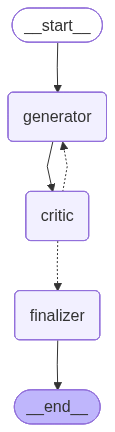

In [92]:
# Visualize
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → generator → critic (loops back to generator) → finalizer → END")

In [93]:
def visualize_scores_bar(scores: list[QualityScore]):
    iterations = list(range(1, len(scores)+1))
    n_iter = len(iterations)
    
    clarity = [s.clarity for s in scores]
    completeness = [s.completeness for s in scores]
    accuracy = [s.accuracy for s in scores]
    overall = [s.overall for s in scores]
    
    bar_width = 0.2
    x = np.arange(n_iter)  # X positions for each iteration

    plt.figure(figsize=(10, 5))
    
    plt.bar(x - 1.5*bar_width, clarity, width=bar_width, label='Clarity', color='blue')
    plt.bar(x - 0.5*bar_width, completeness, width=bar_width, label='Completeness', color='green')
    plt.bar(x + 0.5*bar_width, accuracy, width=bar_width, label='Accuracy', color='orange')
    plt.bar(x + 1.5*bar_width, overall, width=bar_width, label='Overall', color='purple')
    
    plt.xticks(x, [f"Iter {i}" for i in iterations])
    plt.ylim(1, 5)
    plt.ylabel("Score (1-5)")
    plt.title("Reflection Score Improvements (Bar Chart)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()



✍️ Generating initial draft...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 5, "accuracy": 5, "overall": 5}...


✍️ Refining (iteration 1)...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 5, "accuracy": 5, "overall": 5}...


✍️ Refining (iteration 2)...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 5, "accuracy": 5, "overall": 5}...

Max iterations (3) reached


✅ Reflection complete!

Iteration 1: Clarity=5, Completeness=5, Accuracy=5, Overall=5→ Approved!
Iteration 2: Clarity=5, Completeness=5, Accuracy=5, Overall=5→ Approved!
Iteration 3: Clarity=5, Completeness=5, Accuracy=5, Overall=5→ Approved!

📊 FINAL OUTPUT (after reflection):
**Why is the Sky Blue? A Simple Explanation**

The sky appears blue due to a phenomenon called Rayleigh scattering. Let’s break it down in easy-to-understand steps:

1. **Sunlight and Its Colors**: Although sunlight looks white, it is actually made up 

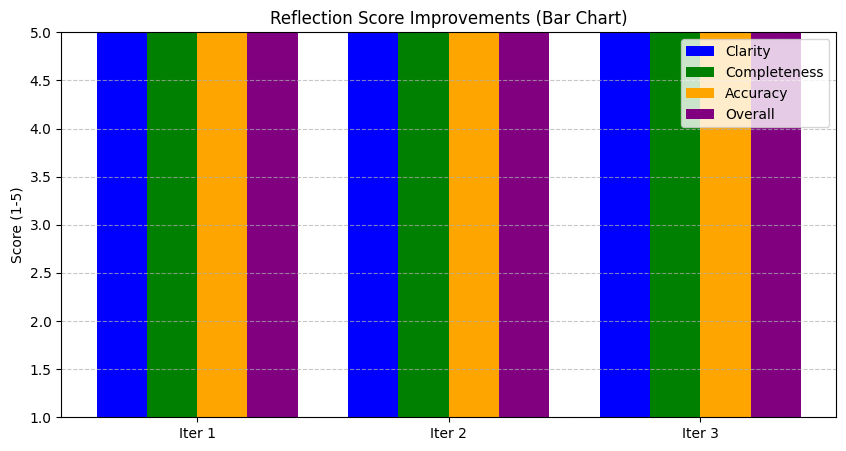

In [94]:
result = reflection_agent.invoke({
    "task": "Explain why the sky is blue in simple terms",
    "draft": "",
    "critique": "",
    "iterations": 0,
    "scores": []
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")

# Visualize
visualize_scores_bar(result["scores"])  


✍️ Generating initial draft...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 5, "accuracy": 5, "overall": 5}...


✍️ Refining (iteration 1)...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 5, "accuracy": 5, "overall": 5}...


✍️ Refining (iteration 2)...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 5, "accuracy": 5, "overall": 5}...

Max iterations (3) reached


✅ Reflection complete!

Iteration 1: Clarity=5, Completeness=5, Accuracy=5, Overall=5→ Approved!
Iteration 2: Clarity=5, Completeness=5, Accuracy=5, Overall=5→ Approved!
Iteration 3: Clarity=5, Completeness=5, Accuracy=5, Overall=5→ Approved!

📊 FINAL OUTPUT (after reflection):
An agentic pattern refers to a behavioral and cognitive framework where individuals actively take charge of their actions and decisions, demonstrating autonomy and self-efficacy. This pattern highlights the ability to recognize and harness one's capaci

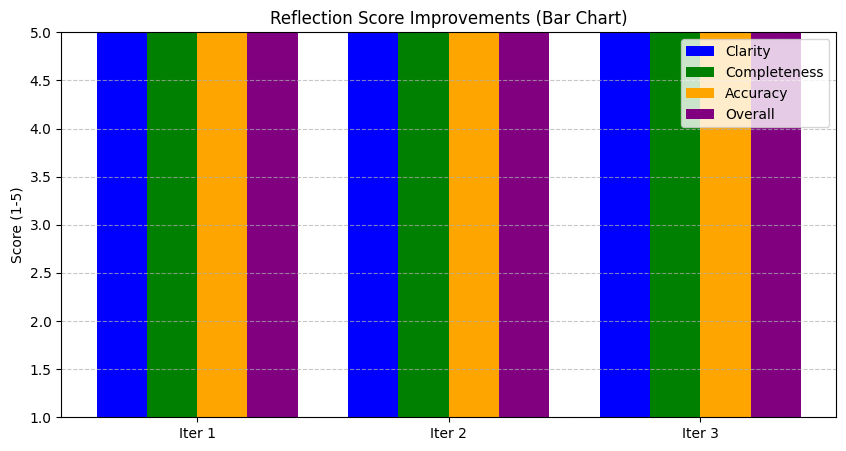

In [95]:
result = reflection_agent.invoke({
    "task": "Explain what an agentic pattern is in 2-3 sentences",
    "draft": "",
    "critique": "",
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")

# Visualize
visualize_scores_bar(result["scores"])


✍️ Generating initial draft...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 4, "completeness": 4, "accuracy": 5, "overall": 4}...


✍️ Refining (iteration 1)...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 4, "completeness": 4, "accuracy": 5, "overall": 4}...


✍️ Refining (iteration 2)...
✓ Draft created

🔍 Critiquing draft...
Critique: {"clarity": 5, "completeness": 4, "accuracy": 5, "overall": 5}...

Max iterations (3) reached


✅ Reflection complete!

Iteration 1: Clarity=4, Completeness=4, Accuracy=5, Overall=4→ Approved!
Iteration 2: Clarity=4, Completeness=4, Accuracy=5, Overall=4→ Approved!
Iteration 3: Clarity=5, Completeness=4, Accuracy=5, Overall=5→ Approved!

📊 FINAL OUTPUT (after reflection):
The ReAct pattern, which stands for "Reasoning and Acting," is a framework in artificial intelligence that combines reasoning capabilities with action-oriented responses. This approach allows AI systems to not only generate answers based on user input 

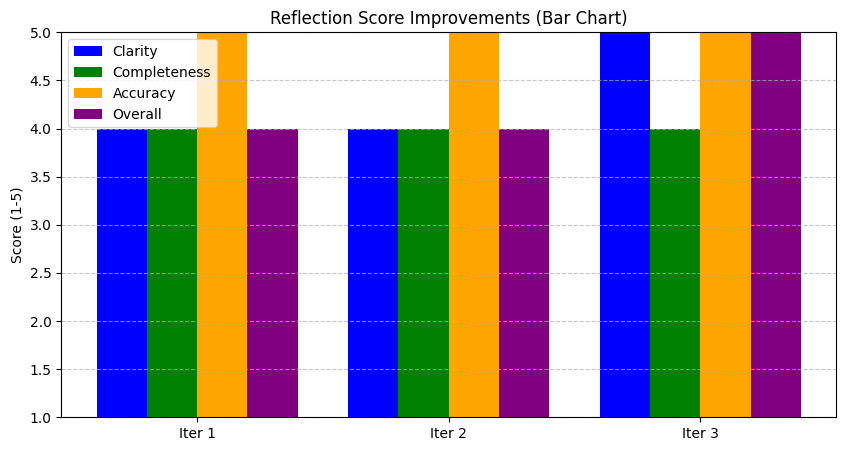

In [96]:
result = reflection_agent.invoke({
    "task": "Explain what is ReAct pattern in 3-4 sentences",
    "draft": "",
    "critique": "",
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")

# Visualize
visualize_scores_bar(result["scores"])